## Table of Content: 
* [1. Data preparation](#section1)

    * [1.1 Load packages and data overview](#section1_1)
    * [1.2 Training and validation set split](#section1_2)
    * [1.3 Plot the time series of training data](#section1_3)

* [2. Model building](#section2)

    * [2.1 Decomposition](#section2_1)
    * [2.2 Seasonal Naive](#section2_2)
    * [2.3 Drift method](#section2_3)
    * [2.4 Holt-Winters](#section2_4)
    * [2.5 SARIMA](#section2_5)
    * [2.6 Neural network](#section2_6)
    * [2.7 LSTM](#section2_7)

* [3. Final model: Holt-Winters](#section3)

# 1. Data preparation <a class="anchor" id="section1"></a >
## 1.1 Load packages and data overview <a class="anchor" id="section1_1"></a >

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sampi
import statsmodels as sm
import statsmodels.api as smt
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.simplefilter('ignore')

In [50]:
# Load training data
df = pd.read_csv('CPI_train.csv')
df['Quarter'] = pd.to_datetime(df['Quarter'])
df.set_index('Quarter', inplace = True)
df.head()

,CPI
Quarter,
1990-03-01,89.1
1990-06-01,90.1
1990-09-01,90.4
1990-12-01,93.8
1991-03-01,93.0


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 1990-03-01 to 2019-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CPI     120 non-null    float64
dtypes: float64(1)
memory usage: 1.9 KB


In [23]:
df.describe()

,CPI
count,120.000000
mean,112.467500
std,11.054275
min,89.100000
25%,102.825000
50%,116.450000
75%,121.325000
max,129.700000


In [51]:
# Load test data
df_test = pd.read_csv('CPI_test.csv')
df_test['Quarter'] = pd.to_datetime(df_test['Quarter'])
df_test.set_index('Quarter', inplace = True)
df_test.head()

,CPI
Quarter,
2020-03-01,127
2020-06-01,128
2020-09-01,129
2020-12-01,130
2021-03-01,131


In [25]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8 entries, 2020-03-01 to 2021-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   CPI     8 non-null      int64
dtypes: int64(1)
memory usage: 128.0 bytes


In [26]:
df_test.describe()

,CPI
count,8.00000
mean,130.50000
std,2.44949
min,127.00000
25%,128.75000
50%,130.50000
75%,132.25000
max,134.00000


## 1.2 Training and validation set split <a class="anchor" id="section1_2"></a >

In [27]:
# Training set
df_training = df[:-8]
df_training

,CPI
Quarter,
1990-03-01,89.1
1990-06-01,90.1
1990-09-01,90.4
1990-12-01,93.8
1991-03-01,93.0
...,...
2016-12-01,124.9
2017-03-01,124.0
2017-06-01,123.3


In [28]:
# Validation set
df_validation = df[-8:]
df_validation

,CPI
Quarter,
2018-03-01,124.8
2018-06-01,124.3
2018-09-01,126.3
2018-12-01,127.8
2019-03-01,125.8
2019-06-01,126.6
2019-09-01,128.5
2019-12-01,129.7


## 1.3 Plot the time series of training data <a class="anchor" id="section1_3"></a >

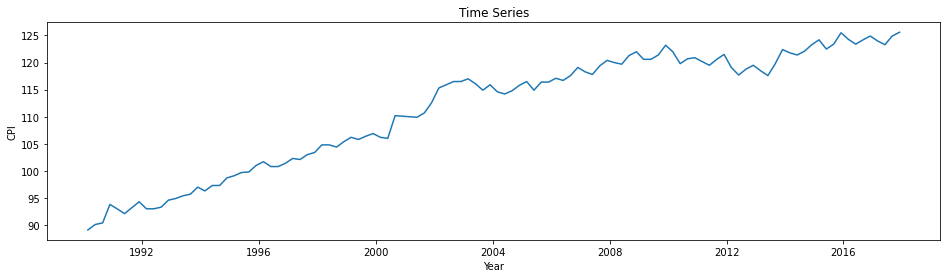

In [29]:
TS = df_training['CPI'] 
plt.figure(figsize = (16,4))
plt.plot(TS)
plt.title("Time Series")
plt.xlabel("Year")
plt.ylabel("CPI")
plt.show()

# 2. Model building <a class="anchor" id="section2"></a >
## 2.1 Decomposition <a class="anchor" id="section2_1"></a >
### (1) Initially estimate the trend-cycle component by moving average

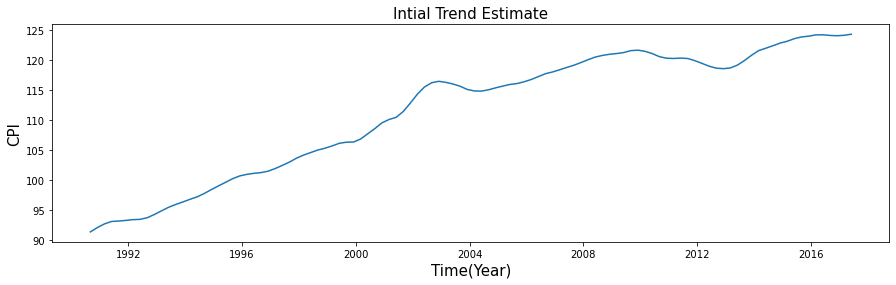

,CPI
Quarter,
1990-03-01,NaN
1990-06-01,NaN
1990-09-01,91.3375
1990-12-01,92.0750
1991-03-01,92.6750
...,...
2016-12-01,124.1125
2017-03-01,124.1875
2017-06-01,124.3625


In [30]:
# Apply CMA-M with M=4 to initially estimate the trend
plt.figure(figsize = (15,4))
ITE = df_training.rolling(4,center=True).mean().rolling(2,center=True).mean().shift(-1)
plt.plot(ITE)
plt.title("Intial Trend Estimate",fontsize=15)
plt.xlabel('Time(Year)',fontsize=15)
plt.ylabel("CPI",fontsize=15)
plt.show()
ITE

### (2) De-trend

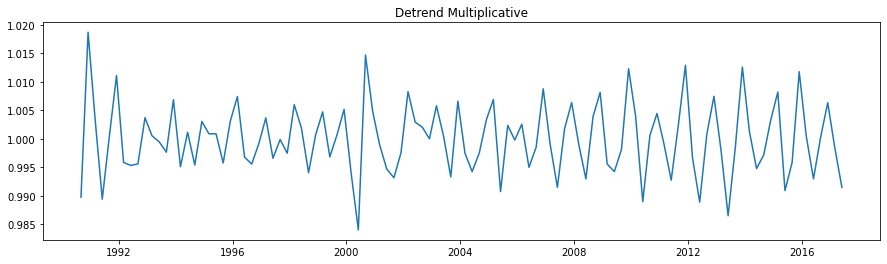

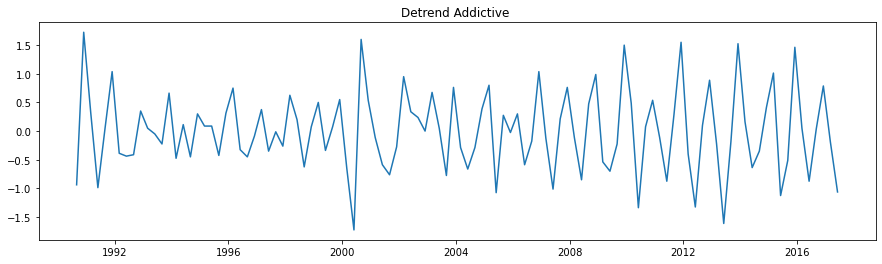

In [31]:
#Multiplicative
TM_detrend = df_training / ITE
plt.figure(figsize = (15,4))
plt.plot(TM_detrend)
plt.title("Detrend Multiplicative")
plt.show


# Additive 
TA_detrend = df_training - ITE
plt.figure(figsize = (15,4))
plt.plot(TA_detrend)
plt.title("Detrend Addictive ")

plt.show()

### (3) Estimate the seasonal indices based on the detrend component and normalization 

In [32]:
#Multiplicative 
TM_detrend_reshape = np.reshape(TM_detrend.to_numpy(),(28,4))
print(TM_detrend_reshape.shape)
TM_detrend_reshape
TM_avg=np.nanmean(TM_detrend_reshape, axis=0)
print(TM_avg)
print(TM_avg.mean())

# Additive 
TA_detrend_reshape = np.reshape(TA_detrend.to_numpy(),(28,4))
print(TA_detrend_reshape.shape)
TA_detrend_reshape
TA_avg=np.nanmean(TA_detrend_reshape, axis=0)
print(TA_avg)
print(TA_avg.mean())

(28, 4)
[1.00116806 0.99429919 0.99873897 1.005776  ]
0.9999955546866266
(28, 4)
[ 0.13101852 -0.65740741 -0.12546296  0.64814815]
-0.0009259259259250807


In [33]:
#Multiplicative
TM_idx = TM_avg.mean()
Mal_normalizaed = TM_avg / TM_idx
print(Mal_normalizaed)
print(Mal_normalizaed.mean())

# Additive 
TA_idx = TA_avg.mean()
Add_normalizaed = TA_avg - TA_idx
print(Add_normalizaed)
print(Add_normalizaed.mean())

[1.00117251 0.99430361 0.99874341 1.00578047]
1.0
[ 0.13194444 -0.65648148 -0.12453704  0.64907407]
2.7755575615628914e-17


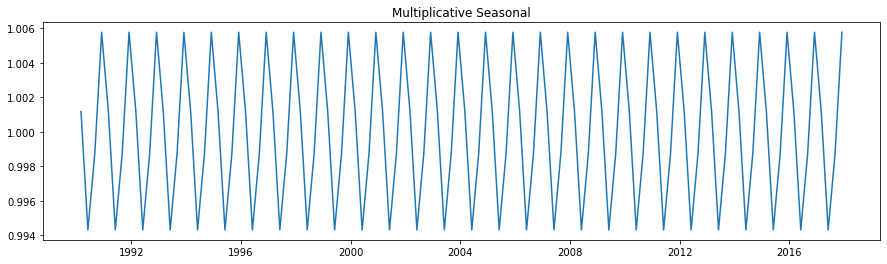

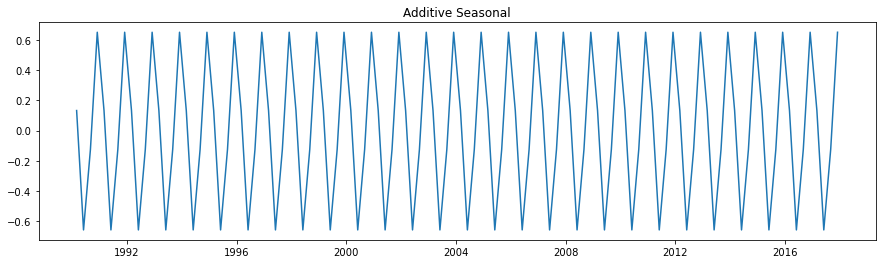

In [34]:
#Multiplicative
Mal_tile = np.tile(Mal_normalizaed, 28)
Mal_tile  = np.reshape(Mal_tile,(28*4,1))
Mal_tile.shape

plt.figure(figsize = (15,4))
plt.plot(df_training.index,Mal_tile)
plt.title("Multiplicative Seasonal")
plt.show()


# Additive 
Add_tile = np.tile(Add_normalizaed, 28)
Add_tile  = np.reshape(Add_tile,(28*4,1))
Add_tile.shape

plt.figure(figsize = (15,4))
plt.plot(df_training.index,Add_tile)
plt.title("Additive Seasonal")
plt.show()

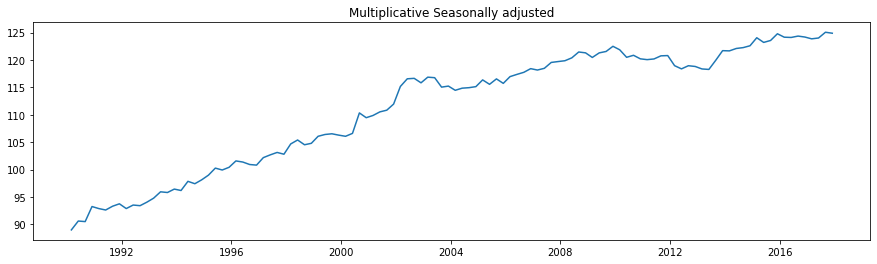

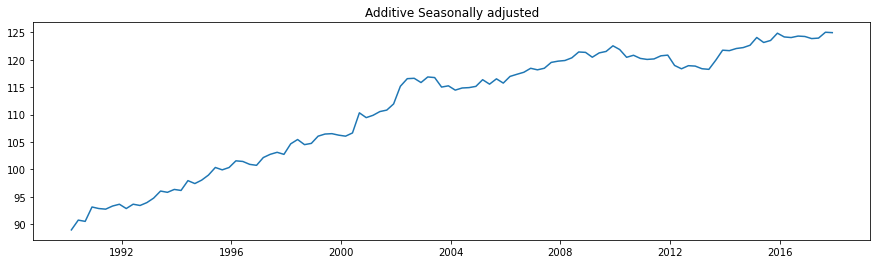

In [35]:
#Multiplicative
SA_mal = df_training / Mal_tile
plt.figure(figsize = (15,4))
plt.plot(SA_mal)
plt.title("Multiplicative Seasonally adjusted")
plt.show()


# Additive 
SA_add = df_training - Add_tile
plt.figure(figsize = (15,4))
plt.plot(SA_add)
plt.title("Additive Seasonally adjusted")
plt.show()

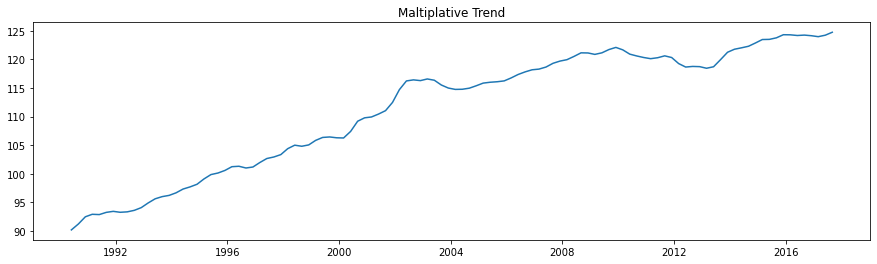

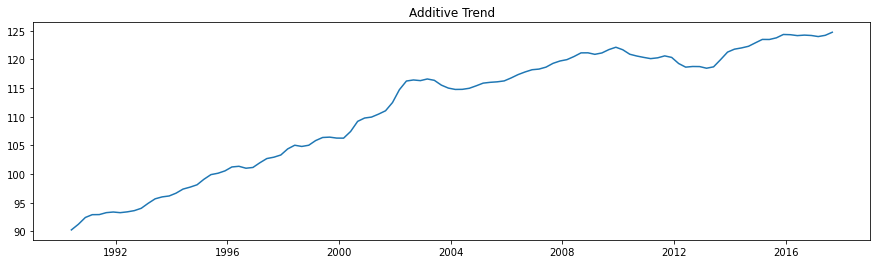

In [36]:
#Multiplicative
Mal_trend = SA_mal.rolling (2, center = True).mean().rolling(2,center = True).mean().shift(-1)[1:-1]
plt.figure(figsize = (15,4))
plt.plot(Mal_trend )
plt.title("Maltiplative Trend")
plt.show()


# Additive 
Add_trend = SA_add.rolling (2, center = True).mean().rolling(2,center = True).mean().shift(-1)[1:-1]
plt.figure(figsize = (15,4))
plt.plot(Add_trend )
plt.title("Additive Trend")
plt.show()

In [37]:
print(Mal_trend.shape)
print(Add_trend.shape)

(110, 1)
(110, 1)


### (4) Forecasting

In [38]:
# Multiplative 
DF_mal = Mal_trend['CPI'].to_list()
for i in range(9):
    DF_mal.append(np.mean(DF_mal[-2:])) 
print(len(DF_mal))


# Additive
DF_add = Add_trend['CPI'].to_list()
for i in range(9):
    DF_add.append(np.mean(DF_add[-2:])) 
print(len(DF_add))


119
119


In [39]:
# Multiplative 
Mal_trend_forecast = DF_mal[-8:]
print(Mal_trend_forecast)


# Additive 
Add_trend_forecast = DF_add[-8:]
print(Add_trend_forecast)


[124.62007353902393, 124.55525722149956, 124.58766538026174, 124.57146130088066, 124.5795633405712, 124.57551232072592, 124.57753783064857, 124.57652507568724]
[124.60468749999998, 124.53747106481481, 124.5710792824074, 124.5542751736111, 124.56267722800925, 124.55847620081018, 124.5605767144097, 124.55952645760993]


In [40]:
# Multiplative
print(Mal_tile .shape)
Mal_forecast = Mal_tile [:8]
print(Mal_forecast)


# Additive 
print(Add_tile .shape)
Add_forecast = Add_tile [:8]
print(Add_forecast)

(112, 1)
[[1.00117251]
 [0.99430361]
 [0.99874341]
 [1.00578047]
 [1.00117251]
 [0.99430361]
 [0.99874341]
 [1.00578047]]
(112, 1)
[[ 0.13194444]
 [-0.65648148]
 [-0.12453704]
 [ 0.64907407]
 [ 0.13194444]
 [-0.65648148]
 [-0.12453704]
 [ 0.64907407]]


In [41]:
# Multiplative
Msum_forecast = (Mal_trend_forecast * Mal_forecast.T).T
print(Msum_forecast.shape)

# Additive 
Tsum_forecast = (Add_trend_forecast + Add_forecast.T).T
print(Tsum_forecast.shape)

(8, 1)
(8, 1)


DatetimeIndex(['2018-03-01', '2018-06-01', '2018-09-01', '2018-12-01',
               '2019-03-01', '2019-06-01', '2019-09-01', '2019-12-01'],
              dtype='datetime64[ns]', name='Quarter', freq=None)


<function matplotlib.pyplot.show(close=None, block=None)>

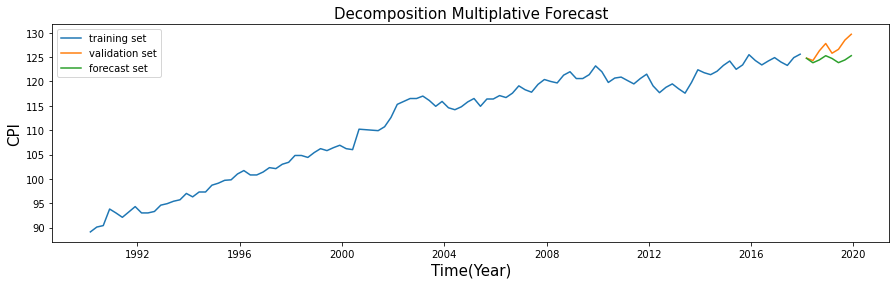

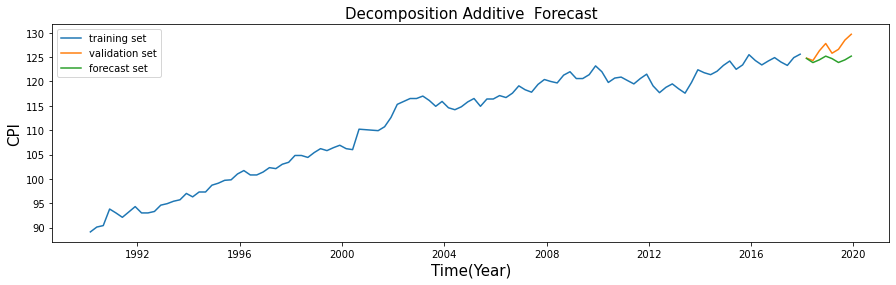

In [42]:
print(df_validation.index)

# Multiplative

plt.figure(figsize=(15,4))
plt.plot(df_training, label = "training set")
plt.plot(df_validation, label = "validation set")
plt.plot(df_validation.index, Msum_forecast, label = "forecast set")
plt.legend()
plt.title("Decomposition Multiplative Forecast",fontsize = 15)
plt.xlabel('Time(Year)',fontsize = 15)
plt.ylabel('CPI',fontsize = 15)
plt.show


# Additive 

plt.figure(figsize=(15,4))
plt.plot(df_training, label = "training set")
plt.plot(df_validation, label = "validation set")
plt.plot(df_validation.index, Tsum_forecast, label = "forecast set")
plt.legend()
plt.title("Decomposition Additive  Forecast",fontsize = 15)
plt.xlabel('Time(Year)',fontsize = 15)
plt.ylabel('CPI',fontsize = 15)
plt.show

### (5) MSE

In [43]:
#https://www.geeksforgeeks.org/python-mean-squared-error/

# Multiplative
Mal_MSE = np.square(np.subtract(df_validation,Msum_forecast)).mean()
print(Mal_MSE)


# Additive 
Add_MSE = np.square(np.subtract(df_validation,Tsum_forecast)).mean()
print(Add_MSE)


CPI    6.83127
dtype: float64
CPI    6.943378
dtype: float64


## 2.2 Seasonal Naive <a class="anchor" id="section2_2"></a >

##### We're already checked there is seasonal pattern in the CPI_train data, so use seasonal Naive to forecast instead of simple navie

In [25]:
# The period of seaonal is 4
sn=df_training['CPI'][-4:].tolist()
sn

[124.0, 123.3, 124.9, 125.6]

In [26]:
# Forecast the next 8 quarter
sn=sn*2
sn

[124.0, 123.3, 124.9, 125.6, 124.0, 123.3, 124.9, 125.6]

In [27]:
# Change the series into dataframe and change the column name
snforecast=pd.DataFrame(sn,columns=['Seasonal Naive forecast'])
snforecast
# https://blog.csdn.net/MinskyYi/article/details/123531301 

,Seasonal Naive forecast
0,124.0
1,123.3
2,124.9
3,125.6
4,124.0
5,123.3
6,124.9
7,125.6


In [28]:
# Put the true data index into forecast data index
snforecast.index = df_validation.index
snforecast


,Seasonal Naive forecast
Quarter,
2018-03-01,124.0
2018-06-01,123.3
2018-09-01,124.9
2018-12-01,125.6
2019-03-01,124.0
2019-06-01,123.3
2019-09-01,124.9
2019-12-01,125.6


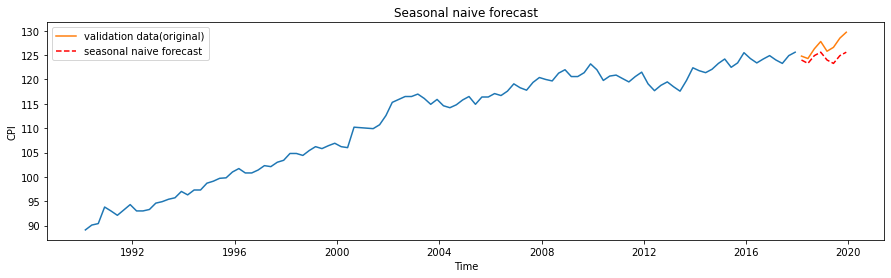

In [29]:
# Plot the time series
plt.figure(figsize=(15,4))
plt.plot(df_training)
plt.plot(df_validation,label='validation data(original)')
plt.plot(snforecast,'--r',label='seasonal naive forecast')
plt.title('Seasonal naive forecast')
plt.xlabel('Time')
plt.ylabel('CPI')
plt.legend()

plt.savefig('seasonal navie.png')
plt.show()

In [30]:
# MSE
MSE_seasonal_naive = np.square(np.subtract(df_validation['CPI'],sn)).mean()
MSE_seasonal_naive

6.5424999999999836

## 2.3 Drift method <a class="anchor" id="section2_3"></a >

We'll try the drift method because there is a sigificant increasing trend in the data.
The drift method is to draw a line into the first value and the last value, and use its extended line to forecast the future values.

In [31]:
# Get first value and last value
frist_number=df_training['CPI'][0]
last_number=df_training['CPI'][111]
print(frist_number)
print(last_number)

89.1
125.6


In [32]:
len(df_validation)+1

9

In [33]:
# Forecasting
dforecast=[]
for i in range(1, 9):
    dforecast.append(last_number+i*(last_number-frist_number)/(len(df_training)-1))
dforecast

[125.92882882882883,
 126.25765765765765,
 126.58648648648648,
 126.91531531531531,
 127.24414414414414,
 127.57297297297296,
 127.9018018018018,
 128.23063063063063]

In [34]:
# Change it into the form of dataframe
dforecast_df=pd.DataFrame(dforecast,columns=['Drift method forecast'])

dforecast_df

,Drift method forecast
0,125.928829
1,126.257658
2,126.586486
3,126.915315
4,127.244144
5,127.572973
6,127.901802
7,128.230631


In [35]:
dforecast_df.index = df_validation.index
dforecast_df

,Drift method forecast
Quarter,
2018-03-01,125.928829
2018-06-01,126.257658
2018-09-01,126.586486
2018-12-01,126.915315
2019-03-01,127.244144
2019-06-01,127.572973
2019-09-01,127.901802
2019-12-01,128.230631


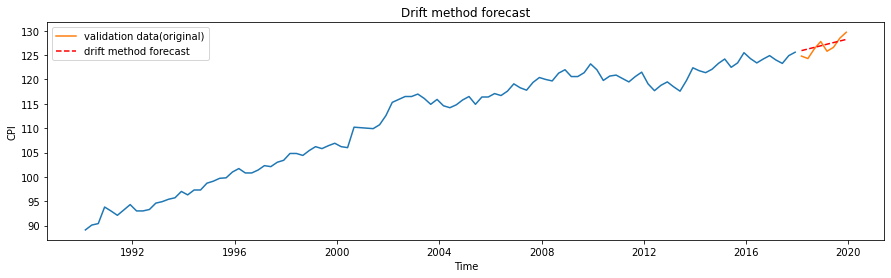

In [36]:
# Plot the time series
plt.figure(figsize=(15,4))
plt.plot(df_training)
plt.plot(df_validation,label='validation data(original)')
plt.plot(dforecast_df,'--r',label='drift method forecast')
plt.title('Drift method forecast')
plt.xlabel('Time')
plt.ylabel('CPI')
plt.legend()
plt.show()

In [37]:
# MSE
MSE_drift=np.square(np.subtract(df_validation['CPI'],dforecast)).mean()
MSE_drift

1.4400669588507358

## 2.4 Holt-Winters <a class="anchor" id="section2_4"></a >

In [52]:
# all the code below are from tutorial 07, 6840
# Step 1: Importing the libraries
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [39]:
# Step 2: Call ExponentialSmoothing function to smooth the time series
fit_add_69 = ExponentialSmoothing(df_training['CPI'], seasonal_periods=4, trend='add', seasonal='add').fit() # Holt-Winters additive smoothing
fit_mul_69 = ExponentialSmoothing(df_training['CPI'], seasonal_periods=4, trend='add', seasonal='mul').fit() # Holt-Winters multiplicative smoothing

In [40]:
results= pd.DataFrame(index=[r"$\alpha$",\
                              r"$\beta$",\
                              r"$\gamma$",\
                              r"$l_0$",\
                              "$b_0$",\
                              "SSE"])

params = ['smoothing_level', \
          'smoothing_trend', \
          'smoothing_seasonal', \
          'initial_level', \
          'initial_trend']

results["Additive"]       = [fit_add_69.params[p] for p in params] + [fit_add_69.sse]
results["Multiplicative"] = [fit_mul_69.params[p] for p in params] + [fit_mul_69.sse]
results=results.round(4)
print(results)

          Additive  Multiplicative
$\alpha$    0.8503          1.0000
$\beta$     0.0000          0.0000
$\gamma$    0.1323          0.0000
$l_0$      89.3096         87.4376
$b_0$       0.3205          0.3186
SSE        91.1542         86.0580


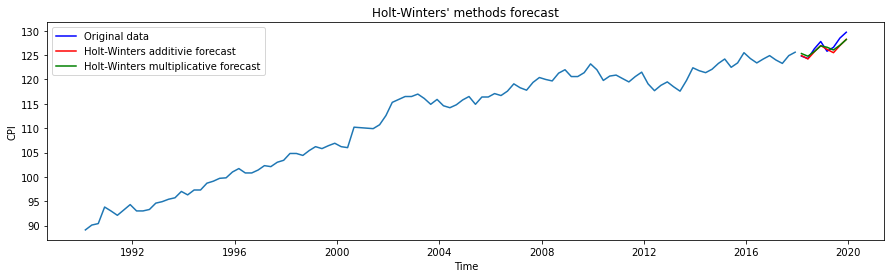

In [41]:
# Step 3: Forecasting
ht_forecast_add_69 = fit_add_69.forecast(8)
ht_forecast_mul_69 = fit_mul_69.forecast(8)


# Step 4: Plot all together
plt.figure(figsize=(15,4))
plt.plot(df_training)
plt.plot(df_validation,'blue',label = 'Original data')
plt.plot(ht_forecast_add_69,'red',label = 'Holt-Winters additivie forecast')
plt.plot(ht_forecast_mul_69,'green', label = 'Holt-Winters multiplicative forecast')
plt.xlabel("Time")
plt.ylabel("CPI")
plt.title("Holt-Winters' methods forecast")
plt.legend()
plt.show()

In [42]:
## Step 5：Comparison of additive vs multiplicative
MSE_holt_winters_add=np.square(np.subtract(df_validation['CPI'],ht_forecast_add_69)).mean()
MSE_holt_winters_mul=np.square(np.subtract(df_validation['CPI'],ht_forecast_mul_69)).mean()
print(MSE_holt_winters_add)
print(MSE_holt_winters_mul)

0.8627061934438969
0.8759947672180153


## 2.5 SARIMA <a class="anchor" id="section2_5"></a >
### (1) Check the original data

<Figure size 2160x432 with 0 Axes>

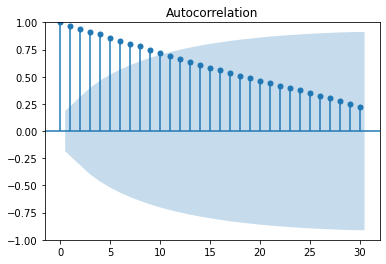

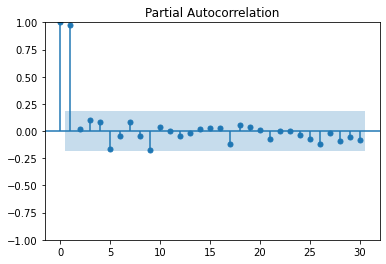

In [43]:
#Take a look at the ACF and PACF for this data set by plotting
plt.figure(figsize=(30,6))
smt.graphics.tsa.plot_acf(df_training, lags=30, alpha = 0.05)
smt.graphics.tsa.plot_pacf(df_training, lags=30, alpha = 0.05)
plt.show()

The ACF in the above graph shows that the mean is not stationary and falls very slowly.

### (2) Check the log data

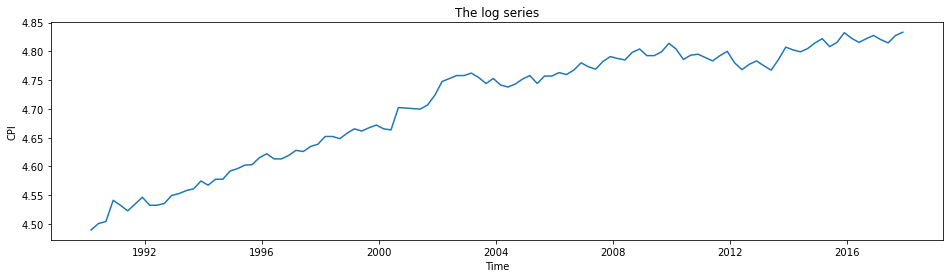

In [44]:
# Log the data
log_train = np.log(TS) 
# Plot the log series
plt.figure(figsize = (16,4))
plt.plot(TS.index,log_train)
plt.xlabel('Time')
plt.ylabel( 'CPI')
plt.title('The log series')
plt.show()

Compared to the previous graph, the range of y is smaller, so log can make the fluctuations in variance smaller, but it does nothing for mean.

<Figure size 2160x432 with 0 Axes>

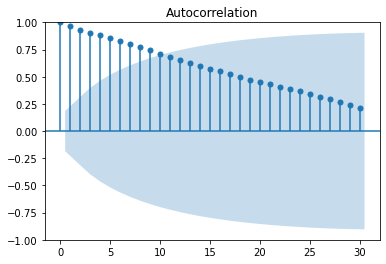

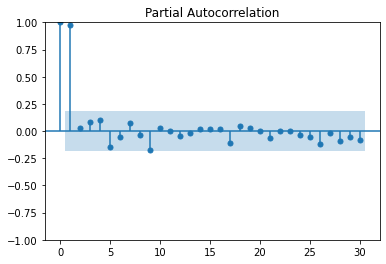

In [45]:
plt.figure(figsize=(30,6))
smt.graphics.tsa.plot_acf(log_train, lags=30, alpha = 0.05)
smt.graphics.tsa.plot_pacf(log_train, lags=30, alpha = 0.05)
plt.show()

**It's is quite clear that log_train is non-stationary, because ACF does not die down quickly. So the next step is to perform 1-order differencing to ts_log and re-examine the ACF and PACF of the differenced data.**

### (3)  $1^{st}$ differencing

Clearly the time is not stationary. So it needs to access the stationarity of the time series to select appropriated integrated value $d$. Therefore, we will do the $1^{st}$ order difference. 

In [46]:
# Take the 1st order diff,to calculate difference series, Y[1]-Y[0], Y[2]-Y[1],...
ts_dif = log_train - log_train.shift()
# Discard the nan value
ts_dif.dropna(inplace=True)
ts_dif

Quarter
1990-06-01    0.011161
1990-09-01    0.003324
1990-12-01    0.036921
1991-03-01   -0.008565
1991-06-01   -0.009725
                ...   
2016-12-01    0.005620
2017-03-01   -0.007232
2017-06-01   -0.005661
2017-09-01    0.012893
2017-12-01    0.005589
Name: CPI, Length: 111, dtype: float64

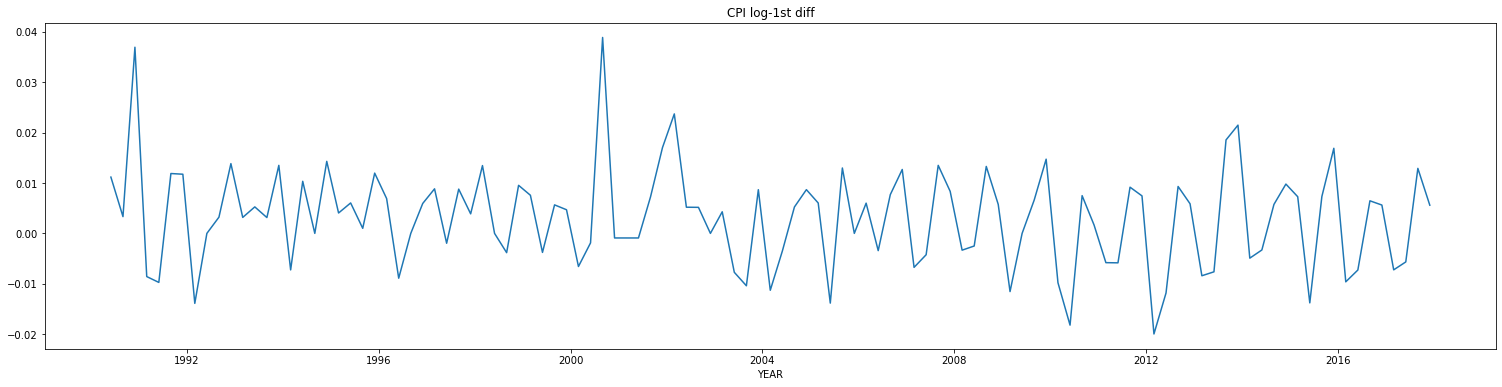

In [47]:
# Plot the 1st-differencing series
plt.figure(figsize = (26,6))
plt.plot(ts_dif)
plt.title('CPI log-1st diff')
plt.xlabel('YEAR')
plt.show()

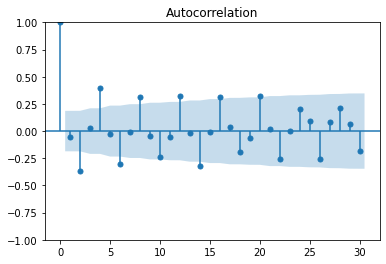

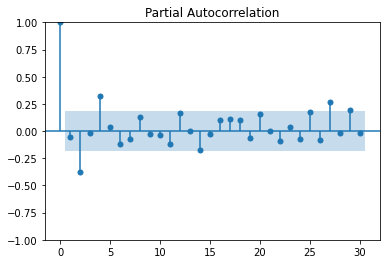

In [48]:
# Plot ACF and PACF
smt.graphics.tsa.plot_acf(ts_dif, lags=30, alpha = 0.05)
plt.show()

smt.graphics.tsa.plot_pacf(ts_dif, lags=30, alpha = 0.05)
plt.show()

### (4) Check the stationarity using Dickey-Fuller test

The ACF and PACF above can be used to check the stationarity of the data. However, for some complex cases, it may not be easy to check whether the data is stationary or not. Therefore, I will use the Dickey-fuller test to ensure that the processed data is stationary.

In [49]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    
    # Print test outputs
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','pvalue','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

def plot_curve(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(12,center=True).mean()
    rolstd = timeseries.rolling(12,center=True).std()

    # Plot rolling statistics:
    plt.figure(figsize=(15,6))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -1.751297
pvalue                           0.404895
#Lags Used                       6.000000
Number of Observations Used    105.000000
Critical Value (1%)             -3.494220
Critical Value (5%)             -2.889485
Critical Value (10%)            -2.581676
dtype: float64


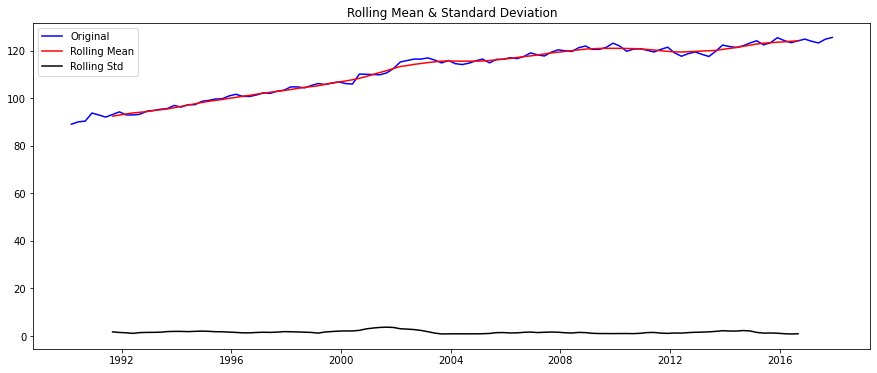

In [50]:
# Call test_stationarity() function to perform Dickey-Fuller test for the original series
test_stationarity(df_training)   

# Then call the plot_curve() to visualize the original, rolling mean and rolling std series
plot_curve(df_training)

Clearly, this is not stationary because the p-value is 0.40, which is higher than significant levels at 1%, 5% and 10% then we do not reject the  𝐻0 , which states that the given time series is non-stationary.

Results of Dickey-Fuller Test:
Test Statistic                  -4.492389
pvalue                           0.000203
#Lags Used                       3.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64


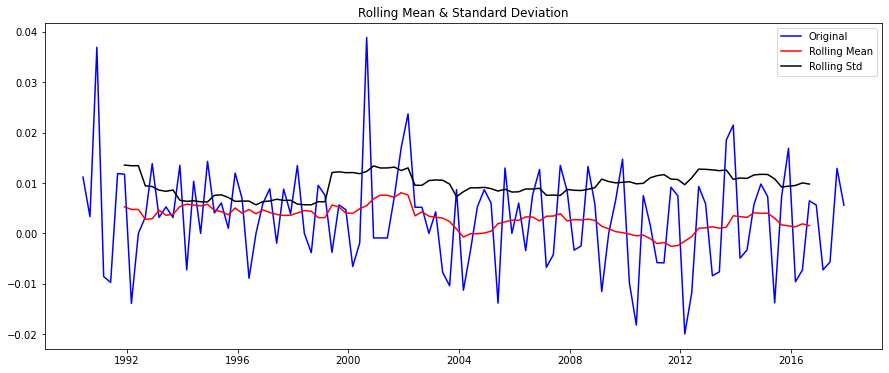

In [51]:
# Call test_stationarity() function to perform Dickey-Fuller test for the de-trended series
test_stationarity(ts_dif)   

# Then call the plot_curve() to visualize the original, rolling mean and rolling std series
plot_curve(ts_dif)

The above output show that the current time series data is stationary because the p-value is 0.000203, which is smaller than significant levels at 1% then we reject the $H_0$ at significant level 1%.

### (5) Using AIC to select best fitting (p,q) order of ARIMA(p,d,q) models 

In [52]:
import statsmodels.tsa.stattools as st 

#select the best fitting order of an ARIMA( 𝑝,𝑞,𝑑 ) model
order = st.arma_order_select_ic(ts_dif,max_ar=5,max_ma=5,ic=['aic'])
print(order.aic_min_order)

(2, 2)


Through the ACF,PACF plot and AIC, which suggest to use  $p = 2$ and $q = 2$ .

There is also a big value at lag 4 in the ACF plot, so the season will be: $m = 4$ .

Since, PACF at lag  $m = 4$  is positive it suggests  $𝑃=1$ . Similarly ACF at lag  $𝑚=4$  is positive and thus $𝑄=0$ .

And there is a differenced series for SARIMA and the seasonal pattern is stable over time,so 𝑑=1, 𝐷=1 .

So the SARIMA $(2,1,2)(1,1,0)_{4}$  model is a reasonable benchmark model.

### (6) Model fitting

In [53]:
# Define a SARIMAX model
model = SARIMAX(log_train, 
                order = (2,1,2),                 # Non-seasonal component
                seasonal_order = (1,1,0,4),     # Seasonal component
                enforce_stationarity = False,
                enforce_invertibility = False)

# Fit the SARIMAX model 
model_fit = model.fit(disp = -1)# The 'disp -1' here means no information about the convergence process is output, True means output
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                CPI   No. Observations:                  112
Model:             SARIMAX(2, 1, 2)x(1, 1, [], 4)   Log Likelihood                 331.313
Date:                            Wed, 25 May 2022   AIC                           -650.626
Time:                                    22:21:12   BIC                           -634.935
Sample:                                03-01-1990   HQIC                          -644.274
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1606      0.772     -0.208      0.835      -1.674       1.352
ar.L2          0.1003      0.908   

In [54]:
# To calculate the length of the dataset for further calculation
len_train = len(df_training) 
len_val = len(df_validation['CPI'])

In [55]:
# Forecast the data
forecast = np.exp(model_fit.forecast(len_val))
forecast

2018-03-01    124.501470
2018-06-01    123.794889
2018-09-01    125.057644
2018-12-01    125.771081
2019-03-01    124.745183
2019-06-01    124.040410
2019-09-01    125.443351
2019-12-01    126.154201
Freq: QS-DEC, Name: predicted_mean, dtype: float64

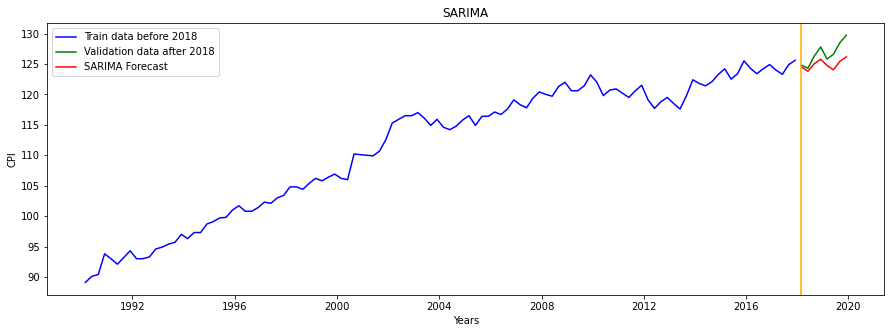

In [56]:
# Plot forecast and true values
plt.figure(figsize=(15,5))
plt.plot(df_training,'blue',label='Train data before 2018')
plt.plot(df_validation,'green',label='Validation data after 2018')
plt.plot(forecast,'red',label='SARIMA Forecast')
plt.title('SARIMA')
plt.xlabel("Years")
plt.ylabel("CPI")
plt.legend()
plt.axvline(x = df_validation.index[0],color = 'orange')  # Make a vertical line indicating train/test separation
plt.show()

### (7) MSE

In [57]:
#To calculate the MSE
Test_SARIMA = np.asarray(df_validation)
Forecast_SARIMA = np.asarray(forecast).reshape(-1,1)

MSE = np.square(np.subtract(Test_SARIMA,Forecast_SARIMA)).mean()
MSE

4.44801956398552

## 2.6 Neural network <a class="anchor" id="section2_6"></a >
### (1) Import required libraries/functions and load the data

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
import math

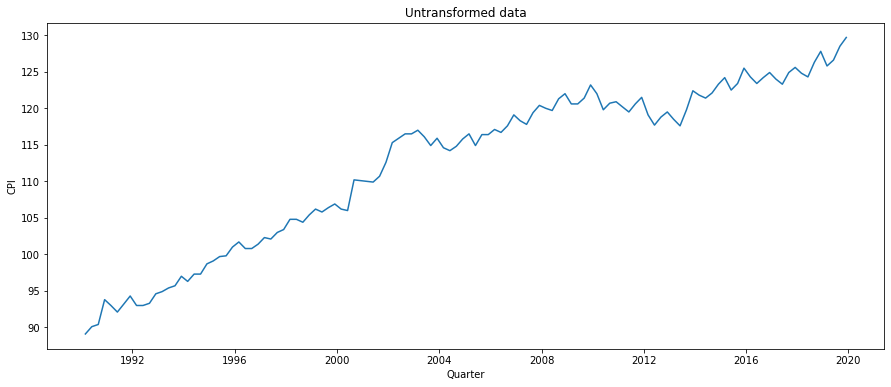

In [5]:
np.random.seed(0)
df = pd.read_csv('CPI_train.csv')
df['Quarter'] = pd.to_datetime(df['Quarter']) ## Convert the data in the Quarter column to datetime
df.set_index('Quarter', inplace = True) ## Indexing the DataFrame by the Quarter column

df_test = pd.read_csv('CPI_test.csv')
df_test['Quarter'] = pd.to_datetime(df_test['Quarter'])
df_test.set_index('Quarter', inplace = True)

df_new = df.dropna() # Drop all Nans
df_new = df_new.values   # Convert data from Dataframe to array       
df_new = df_new.astype('float') # make sure the data is type of float

# Plot the time series
ts = df["CPI"]
plt.figure(figsize=(15,6))
plt.plot(df.index, df_new)
plt.xlabel('Quarter')
plt.ylabel('CPI')
plt.title('Untransformed data')
plt.show()

### (2) Data pre-processing and train/test split

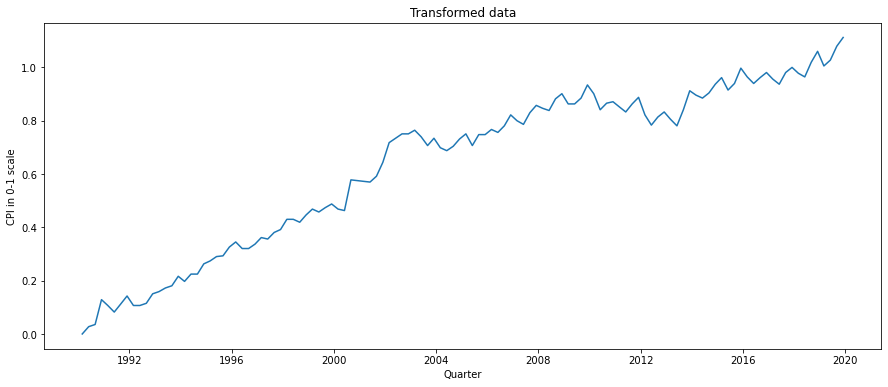

In [17]:
# Time window to define the number of features in each row
time_window = 8
# Define a scaler object
scaler = MinMaxScaler(feature_range=(0, 1))

# Compute train & test size
df_new_size = 112-time_window
validation_size = 8

# Fitting the scaler
fit_scaler = scaler.fit(df_new[:df_new_size+time_window])

# Transforming using trained scaler
df_scaled = fit_scaler.transform(df_new)

# Plot the scaled data
plt.figure(figsize=(15,6))
plt.plot(df.index, df_scaled)
plt.xlabel('Quarter')
plt.ylabel('CPI in 0-1 scale')
plt.title('Transformed data')
plt.show()

### (3) Creat  training and testing features

In [18]:
# Time window to define the number of features in each row
time_window = 8
# Pre-allocation
X_df_train_all, Y_df_train_all = [], []
# Use each rolling window as a row in the data matrix 
for i in range(time_window, len(df_scaled)):
    X_df_train_all.append(df_scaled[i-time_window:i, 0])
    Y_df_train_all.append(df_scaled[i, 0])
# Convert them from list to array
X_df_train_all = np.array(X_df_train_all)
Y_df_train_all = np.array(Y_df_train_all)


# Training data
Xdf_train = X_df_train_all[:df_new_size, :]
Ydf_train = Y_df_train_all[:df_new_size]



In [19]:
Xdf_train.shape

(104, 8)

### (4) Define the Feed Forward Neual Network model

In [20]:
#Define model
np.random.seed(0)
model_nn = Sequential()
model_nn.add(Dense(22, input_dim = time_window, activation='relu'))
model_nn.add(Dense(1))

### (5) Compile

In [21]:
model_nn.compile(loss='mean_squared_error', optimizer='adam')
model_nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 22)                198       
                                                                 
 dense_3 (Dense)             (None, 1)                 23        
                                                                 
Total params: 221
Trainable params: 221
Non-trainable params: 0
_________________________________________________________________


### (6) Train the the Feed Forward NN model

In [27]:
np.random.seed(0)
# Training
model_nn.fit(Xdf_train, Ydf_train, epochs=150, batch_size=40 , verbose=1)

Epoch 1/150
3/3 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 2/150
3/3 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 3/150
3/3 [==============================] - 0s 7ms/step - loss: 0.0015
Epoch 4/150
3/3 [==============================] - 0s 8ms/step - loss: 0.0015
Epoch 5/150
3/3 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 6/150
3/3 [==============================] - 0s 8ms/step - loss: 0.0015
Epoch 7/150
3/3 [==============================] - 0s 24ms/step - loss: 0.0015
Epoch 8/150
3/3 [==============================] - 0s 8ms/step - loss: 0.0015
Epoch 9/150
3/3 [==============================] - 0s 3ms/step - loss: 0.0015
Epoch 10/150
3/3 [==============================] - 0s 3ms/step - loss: 0.0015
Epoch 11/150
3/3 [==============================] - 0s 10ms/step - loss: 0.0015
Epoch 12/150
3/3 [==============================] - 0s 3ms/step - loss: 0.0015
Epoch 13/150
3/3 [==============================] - 0s 3ms/

### (7) Multi-Step-ahead forecast

In [28]:
multi_prediction = np.copy(df_scaled[:len(df_scaled)-validation_size])

np.random.seed(0)

for i in range(len(df_scaled)-validation_size, len(df_scaled)):
    last_new_fea = np.reshape(multi_prediction[i-time_window:i], (1,time_window))
    next_new_pred = model_nn.predict(last_new_fea)
    multi_prediction = np.append(multi_prediction, next_new_pred)

# Transform forecast values to original scale    
multi_prediction = multi_prediction.reshape(-1,1)
multi_prediction = scaler.inverse_transform(multi_prediction)

#reference: Nick,N.(2022, May18).QBUS6840 Predictive Analytics, Module Group Assignment[Tutorial 11]. University of Sydney Business School. Retrieved from:https://canvas.sydney.edu.au/courses/40417/pages/tutorial-11?module_item_id=1505643

In [29]:
multi_prediction.shape

(120, 1)

In [30]:
df = pd.read_csv('CPI_train.csv')
df['Quarter'] = pd.to_datetime(df['Quarter']) ## Convert the data in the Quarter column to datetime
df.set_index('Quarter', inplace = True) ## Indexing the DataFrame by the Quarter column


df_test = pd.read_csv('CPI_test.csv')
df_test['Quarter'] = pd.to_datetime(df_test['Quarter'])
df_test.set_index('Quarter', inplace = True)

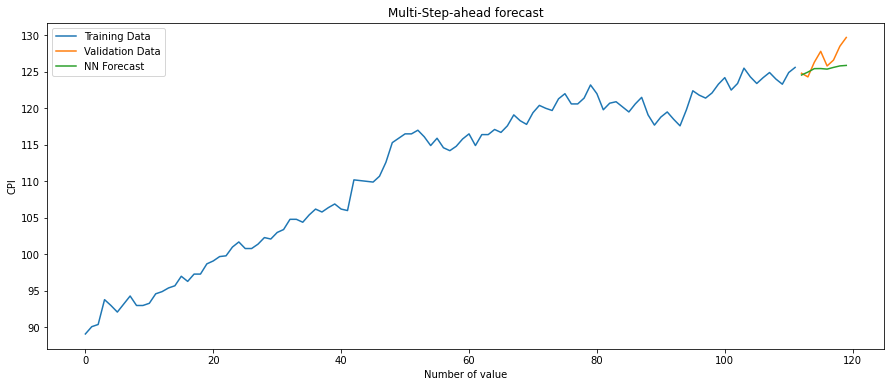

In [31]:
# Plot forecast and test values
plt.figure(figsize=(15,6))

#plt.plot(df, label = "Train")
#plt.plot(df_test.index, multi_prediction[-8:], label = "NN Forecast")
#plt.plot(df_test, label = "Test")

plt.plot(scaler.inverse_transform(df_scaled[:len(df_scaled)-validation_size]), label='Training Data')
plt.plot(np.arange(len(df_scaled)-validation_size, len(df_scaled), 1), scaler.inverse_transform(df_scaled[-validation_size:]), label='Validation Data')
plt.plot(np.arange(len(df_scaled)-validation_size, len(df_scaled), 1), multi_prediction[-validation_size:], label = "NN Forecast")


plt.xlabel('Number of value')
plt.ylabel('CPI')
plt.title('Multi-Step-ahead forecast')
plt.legend()
plt.show()

In [32]:
#reference:https://www.geeksforgeeks.org/python-mean-squared-error/
Y_true = np.array(df[-8:])
MSE = np.square(np.subtract(Y_true, multi_prediction[-8:])).mean()
print("MSE is {:.4f}".format(MSE))

MSE is 3.7379


## 2.7 LSTM <a class="anchor" id="section2_7"></a >
### (1) Import libraries and data overview

In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Activation
from tensorflow.keras.models import Sequential

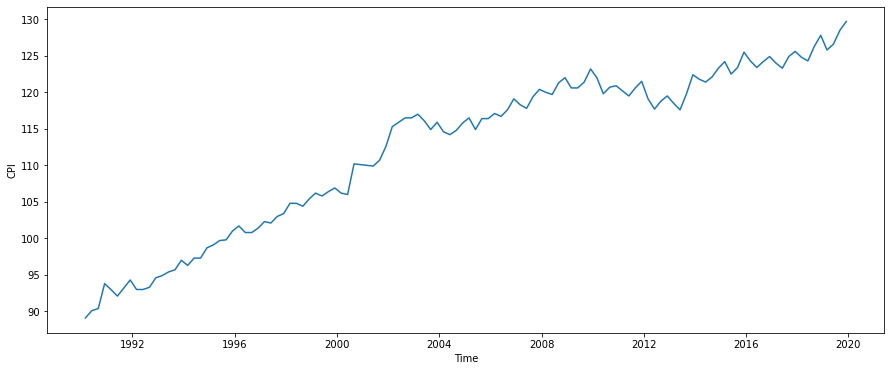

In [5]:
# Convert data from Dataframe to array
data_not_scaled = df.values            # Convert from DataFrame to Python Array
data_not_scaled = data_not_scaled.astype('float')  # data is type of float

# Plot the time series
plt.figure(figsize=(15,6))
plt.plot(df.index,data_not_scaled)
plt.xlabel('Time')
plt.ylabel('CPI')
plt.show()

### (2) Data pre-processing and train/val split

In [6]:
# Define Hyperparameters
time_window = 15
unit = 16   # hidden neurons  #64 
batch = 16

In [7]:
# Time window to define the number of features in each row
time_window = time_window 

# Define a scaler object
scaler = MinMaxScaler(feature_range=(0, 1))

# Compute in-sample and out-of-sample size
val_size = 8
train_size = 112-time_window

# Fitting the scaler
fitted_transformer = scaler.fit(data_not_scaled[:train_size+time_window])

# Transforming using trained scaler
data_scaled = fitted_transformer.transform(data_not_scaled)

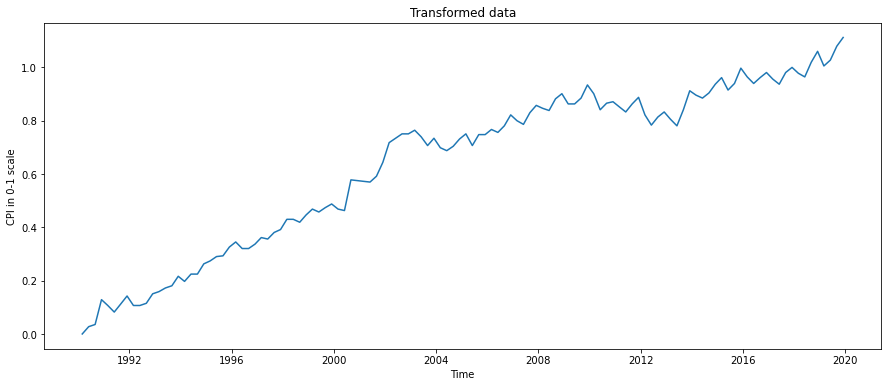

In [8]:
# Plot the scaled data
plt.figure(figsize=(15,6))
plt.plot(df.index, data_scaled)
plt.xlabel('Time')
plt.ylabel('CPI in 0-1 scale')
plt.title('Transformed data')
plt.show()

In [9]:
# Pre-allocation
Xall, Yall = [], []

# Use each rolling window as a row in the data matrix 
for i in range(time_window, len(data_scaled)):
    Xall.append(data_scaled[i-time_window:i, 0])
    Yall.append(data_scaled[i, 0])

# Convert them from list to array
Xall = np.array(Xall)
Yall = np.array(Yall)

# Training data
Xtrain = Xall[:train_size, :]
Ytrain = Yall[:train_size]

# Test data
Xval = Xall[-val_size:, :]
Yval = Yall[-val_size:]

print(Xtrain.shape, Ytrain.shape, Xval.shape, Yval.shape)

(97, 15) (97,) (8, 15) (8,)


### (3) LSTM modelling

In [10]:
# For time series and LSTM layer we need to reshape into 3D array 
Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], time_window,1))
Xval = np.reshape(Xval, (Xval.shape[0], time_window,1))

In [11]:
# Define model
np.random.seed(0)

model = Sequential()
model.add(LSTM(units = unit,input_shape = (time_window,1), activation = 'relu',return_sequences = False)) 
# units = 2^
model.add(Dense(units = 1))    #1 output   
model.add(Activation('linear'))

# Compile
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16)                1152      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________


2022-05-29 12:07:02.030771: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### (4) Train the model with Early Stopping

In [12]:
np.random.seed(0)
# Train the model with Early Stopping
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1)

model.fit(Xtrain, Ytrain, 
          batch_size = batch,             # batch_size = 2^
          epochs = 300,               
          validation_split = 0.05, 
          shuffle = False,
          verbose = 1, 
          callbacks = [early_stop])


Epoch 1/300
6/6 [==============================] - 1s 52ms/step - loss: 1.0158 - val_loss: 1.8290
Epoch 2/300
6/6 [==============================] - 0s 9ms/step - loss: 0.8921 - val_loss: 1.6230
Epoch 3/300
6/6 [==============================] - 0s 9ms/step - loss: 0.7862 - val_loss: 1.4443
Epoch 4/300
6/6 [==============================] - 0s 9ms/step - loss: 0.6946 - val_loss: 1.2889
Epoch 5/300
6/6 [==============================] - 0s 8ms/step - loss: 0.6147 - val_loss: 1.1528
Epoch 6/300
6/6 [==============================] - 0s 9ms/step - loss: 0.5445 - val_loss: 1.0319
Epoch 7/300
6/6 [==============================] - 0s 8ms/step - loss: 0.4821 - val_loss: 0.9230
Epoch 8/300
6/6 [==============================] - 0s 8ms/step - loss: 0.4260 - val_loss: 0.8237
Epoch 9/300
6/6 [==============================] - 0s 8ms/step - loss: 0.3750 - val_loss: 0.7320
Epoch 10/300
6/6 [==============================] - 0s 9ms/step - loss: 0.3284 - val_loss: 0.6464
Epoch 11/300
6/6 [==========

### (5) Dynamic forecast with LSTM

1/1 [==============================] - 0s 19ms/step


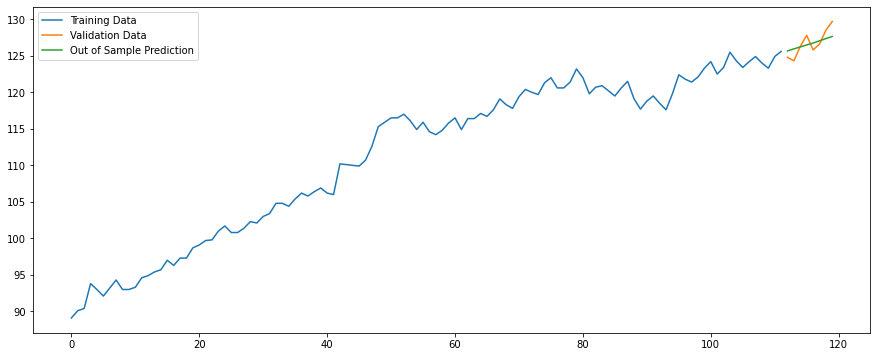

In [13]:
np.random.seed(0)
#Dynamical Prediction
dynamic_prediction = np.copy(data_scaled[:len(data_scaled) - val_size])    # train + time window

for i in range(len(data_scaled) - val_size, len(data_scaled)):
    last_feature = np.reshape(dynamic_prediction[i-time_window:i], (1,time_window,1))
    next_pred = model.predict(last_feature)
    dynamic_prediction = np.append(dynamic_prediction, next_pred)

# Transform forecast values to original scale
dynamic_prediction = dynamic_prediction.reshape(-1,1)
dynamic_prediction_original_scale = scaler.inverse_transform(dynamic_prediction)

# Plot
val_index = np.arange(len(data_scaled) - val_size, len(data_scaled), 1)

plt.figure(figsize=(15,6))
plt.plot(scaler.inverse_transform(data_scaled[:len(data_scaled) - val_size]), label='Training Data')
plt.plot(val_index, scaler.inverse_transform(data_scaled[-val_size:]), label='Validation Data')
plt.plot(val_index, dynamic_prediction_original_scale[-val_size:], label='Out of Sample Prediction') 
plt.legend(loc = "upper left")
plt.show()

### (6) MSE

In [18]:
# Compute MSE score on original test data
val_original_scale = df['CPI'][-val_size:]
pred = dynamic_prediction_original_scale[-val_size:].flatten()
valScore = np.square(np.subtract(val_original_scale, pred)).mean()

print('LSTM MSE: {0:.4f}'.format(valScore))

LSTM MSE: 1.4763


# 3. Final model: Holt-Winters <a class="anchor" id="section3"></a >

In [53]:
# Call ExponentialSmoothing function to smooth the time series
fit_add = ExponentialSmoothing(df['CPI'], seasonal_periods=4, trend='add', seasonal='add').fit() # Holt-Winters additive smoothing
fit_mul = ExponentialSmoothing(df['CPI'], seasonal_periods=4, trend='add', seasonal='mul').fit() # Holt-Winters multiplicative smoothing

In [54]:
results_new= pd.DataFrame(index=[r"$\alpha$",\
                              r"$\beta$",\
                              r"$\gamma$",\
                              r"$l_0$",\
                              "$b_0$",\
                              "SSE"])

params = ['smoothing_level', \
          'smoothing_trend', \
          'smoothing_seasonal', \
          'initial_level', \
          'initial_trend']

results_new["Additive"]       = [fit_add.params[p] for p in params] + [fit_add.sse]
results_new["Multiplicative"] = [fit_mul.params[p] for p in params] + [fit_mul.sse]
results_new=results_new.round(4)
print(results_new)

          Additive  Multiplicative
$\alpha$    0.8562          0.9099
$\beta$     0.0000          0.0000
$\gamma$    0.1183          0.0000
$l_0$      89.3191         86.6369
$b_0$       0.3332          0.3256
SSE        95.0059         92.1124


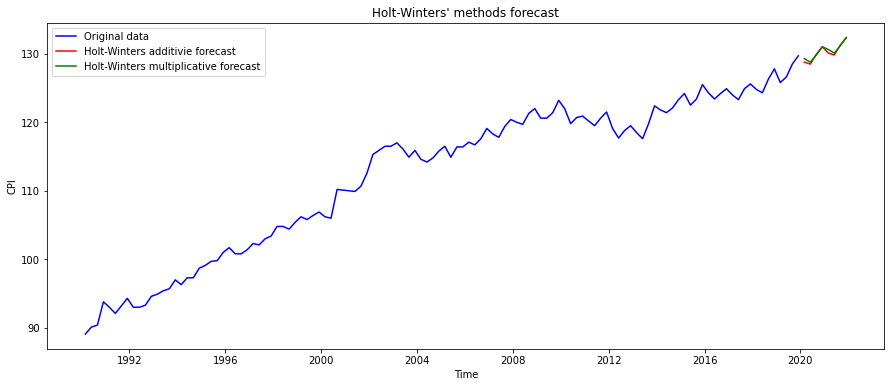

In [55]:
# Forecasting
ht_forecast_add = fit_add.forecast(8)
ht_forecast_mul = fit_mul.forecast(8)


# Plot all together
plt.figure(figsize=(15,6))

plt.plot(df,'blue',label = 'Original data')
plt.plot(ht_forecast_add,'red',label = 'Holt-Winters additivie forecast')
plt.plot(ht_forecast_mul,'green', label = 'Holt-Winters multiplicative forecast')
plt.xlabel("Time")
plt.ylabel("CPI")
plt.title("Holt-Winters' methods forecast")
plt.legend()
plt.show()

In [56]:
ht_forecast_add

2020-03-01    128.783924
2020-06-01    128.488668
2020-09-01    129.930340
2020-12-01    131.013946
2021-03-01    130.116638
2021-06-01    129.821382
2021-09-01    131.263054
2021-12-01    132.346660
Freq: QS-DEC, dtype: float64

In [57]:
ht_forecast_add_np=ht_forecast_add.to_numpy()

In [58]:
# Export data to csv
df_test['CPI'] = ht_forecast_add_np
df_test.to_csv('Group_69_forecast.csv')

In [59]:
# Compute test error
import pandas as pd
cpi_test = pd.read_csv('CPI_test.csv')
test = cpi_test['CPI']
pred = ht_forecast_add_np.flatten()
test_error = np.square(np.subtract(test, pred)).mean()

print(test_error)

2.0740026892095074
